In [1]:
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
import cv2
from PIL import Image
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#from skimage import io, transform
from tqdm import trange, tqdm
import csv
import glob
import dlib
import pandas as pd
import numpy as np
from models.inception_resnet_v1 import InceptionResnetV1
import faceBlendCommon as fbc

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
device

device(type='cuda')

In [4]:
def align_image():
    data_dir = 'data/test_me'
    for train_test in ['train','val']:
        train_test_path=os.path.join(data_dir,train_test)
        for person_folder in os.listdir(train_test_path):
            folder_path=os.path.join(train_test_path,person_folder)
            for each_file in os.listdir(folder_path):
                align_and_save(os.path.join(folder_path,each_file))

In [5]:
def align_and_save(file):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    print(file)
    im=cv2.imread(file)
    faceRects=detector(im,0)
    
    points = fbc.getLandmarks(detector, predictor, im)
    points=np.array(points)
    im = np.float32(im)/255.0
    
    h=600
    w=600
    imNorm, points = fbc.normalizeImagesAndLandmarks((h,w), im, points)
    imNorm = np.uint8(imNorm*255)
    cv2.imwrite(file,imNorm)

In [6]:
#align_image()

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((160,160)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((160,160)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = 'data/test_me'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=10, 
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
class_names

['Dhoni',
 'amrish-puri',
 'irrfan-khan',
 'mahatma-gandhi',
 'narendra-modi',
 'nitish-kumar',
 'rahul-gandhi',
 'ratan_tata',
 'sachin',
 'shahrukh']

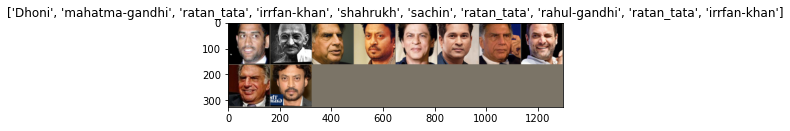

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [9]:
from models.inception_resnet_v1 import InceptionResnetV1
print('Running on device: {}'.format(device))
model_ft = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes = len(class_names))

Running on device: cuda


In [10]:
#model_ft.logits = nn.Linear(512, len(class_names))
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
list(model_ft.children())

[BasicConv2d(
   (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
   (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
 ),
 BasicConv2d(
   (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
   (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
 ),
 BasicConv2d(
   (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
 ),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 BasicConv2d(
   (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
 ),
 BasicConv2d(
   (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
   (bn): BatchNorm2d(192, ep

In [12]:
def train_model(model, criterion, optimizer, scheduler,
                num_epochs=25):
    since = time.time()
    FT_losses = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
    # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                
                FT_losses.append(loss.item())
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, FT_losses

Epoch 0/499
----------
train Loss: 1.8561 Acc: 0.4000
val Loss: 1.2354 Acc: 0.7500
Epoch 1/499
----------
train Loss: 1.2239 Acc: 0.8100
val Loss: 1.1340 Acc: 0.8500
Epoch 2/499
----------
train Loss: 1.1978 Acc: 0.7800
val Loss: 1.1532 Acc: 0.8500
Epoch 3/499
----------
train Loss: 1.1504 Acc: 0.8200
val Loss: 1.1483 Acc: 0.8500
Epoch 4/499
----------
train Loss: 1.1944 Acc: 0.8500
val Loss: 1.1616 Acc: 0.8000
Epoch 5/499
----------
train Loss: 1.1323 Acc: 0.8100
val Loss: 1.1565 Acc: 0.8000
Epoch 6/499
----------
train Loss: 1.2220 Acc: 0.7800
val Loss: 1.1495 Acc: 0.8000
Epoch 7/499
----------
train Loss: 1.2458 Acc: 0.7600
val Loss: 1.1474 Acc: 0.8500
Epoch 8/499
----------
train Loss: 1.1808 Acc: 0.7900
val Loss: 1.1440 Acc: 0.8500
Epoch 9/499
----------
train Loss: 1.1448 Acc: 0.8300
val Loss: 1.1438 Acc: 0.8500
Epoch 10/499
----------
train Loss: 1.2012 Acc: 0.8300
val Loss: 1.1443 Acc: 0.8500
Epoch 11/499
----------
train Loss: 1.2368 Acc: 0.7800
val Loss: 1.1533 Acc: 0.8500
Ep

val Loss: 1.1493 Acc: 0.8500
Epoch 98/499
----------
train Loss: 1.1961 Acc: 0.8400
val Loss: 1.1544 Acc: 0.8000
Epoch 99/499
----------
train Loss: 1.1725 Acc: 0.8100
val Loss: 1.1479 Acc: 0.9000
Epoch 100/499
----------
train Loss: 1.1763 Acc: 0.8200
val Loss: 1.1547 Acc: 0.8000
Epoch 101/499
----------
train Loss: 1.2113 Acc: 0.7900
val Loss: 1.1450 Acc: 0.8500
Epoch 102/499
----------
train Loss: 1.2221 Acc: 0.7800
val Loss: 1.1470 Acc: 0.8500
Epoch 103/499
----------
train Loss: 1.2087 Acc: 0.7700
val Loss: 1.1447 Acc: 0.8500
Epoch 104/499
----------
train Loss: 1.1838 Acc: 0.8700
val Loss: 1.1403 Acc: 0.9000
Epoch 105/499
----------
train Loss: 1.2275 Acc: 0.8000
val Loss: 1.1432 Acc: 0.8500
Epoch 106/499
----------
train Loss: 1.2189 Acc: 0.7900
val Loss: 1.1349 Acc: 0.8500
Epoch 107/499
----------
train Loss: 1.2326 Acc: 0.7700
val Loss: 1.1410 Acc: 0.8500
Epoch 108/499
----------
train Loss: 1.1677 Acc: 0.8000
val Loss: 1.1525 Acc: 0.8500
Epoch 109/499
----------
train Loss: 1

train Loss: 1.2079 Acc: 0.8200
val Loss: 1.1529 Acc: 0.8500
Epoch 195/499
----------
train Loss: 1.2109 Acc: 0.7800
val Loss: 1.1560 Acc: 0.8500
Epoch 196/499
----------
train Loss: 1.1742 Acc: 0.8100
val Loss: 1.1682 Acc: 0.8500
Epoch 197/499
----------
train Loss: 1.1843 Acc: 0.7900
val Loss: 1.1615 Acc: 0.8500
Epoch 198/499
----------
train Loss: 1.1671 Acc: 0.8100
val Loss: 1.1542 Acc: 0.8500
Epoch 199/499
----------
train Loss: 1.1927 Acc: 0.7900
val Loss: 1.1448 Acc: 0.8500
Epoch 200/499
----------
train Loss: 1.1961 Acc: 0.7600
val Loss: 1.1459 Acc: 0.8500
Epoch 201/499
----------
train Loss: 1.2247 Acc: 0.8300
val Loss: 1.1403 Acc: 0.8500
Epoch 202/499
----------
train Loss: 1.1700 Acc: 0.8300
val Loss: 1.1520 Acc: 0.8500
Epoch 203/499
----------
train Loss: 1.1788 Acc: 0.7900
val Loss: 1.1474 Acc: 0.8500
Epoch 204/499
----------
train Loss: 1.2059 Acc: 0.7900
val Loss: 1.1568 Acc: 0.8000
Epoch 205/499
----------
train Loss: 1.1599 Acc: 0.8100
val Loss: 1.1502 Acc: 0.8500
Epoch

train Loss: 1.2148 Acc: 0.7700
val Loss: 1.1625 Acc: 0.8500
Epoch 292/499
----------
train Loss: 1.2030 Acc: 0.7800
val Loss: 1.1549 Acc: 0.8500
Epoch 293/499
----------
train Loss: 1.2425 Acc: 0.7800
val Loss: 1.1467 Acc: 0.8500
Epoch 294/499
----------
train Loss: 1.1950 Acc: 0.7800
val Loss: 1.1481 Acc: 0.8500
Epoch 295/499
----------
train Loss: 1.1903 Acc: 0.8200
val Loss: 1.1515 Acc: 0.8500
Epoch 296/499
----------
train Loss: 1.2015 Acc: 0.7900
val Loss: 1.1569 Acc: 0.8500
Epoch 297/499
----------
train Loss: 1.1818 Acc: 0.8300
val Loss: 1.1541 Acc: 0.8500
Epoch 298/499
----------
train Loss: 1.2349 Acc: 0.7700
val Loss: 1.1491 Acc: 0.8500
Epoch 299/499
----------
train Loss: 1.2424 Acc: 0.7500
val Loss: 1.1461 Acc: 0.8500
Epoch 300/499
----------
train Loss: 1.2338 Acc: 0.7500
val Loss: 1.1369 Acc: 0.8500
Epoch 301/499
----------
train Loss: 1.1782 Acc: 0.8000
val Loss: 1.1469 Acc: 0.8500
Epoch 302/499
----------
train Loss: 1.1849 Acc: 0.8000
val Loss: 1.1497 Acc: 0.8000
Epoch

train Loss: 1.2377 Acc: 0.8000
val Loss: 1.1465 Acc: 0.8500
Epoch 389/499
----------
train Loss: 1.1952 Acc: 0.7900
val Loss: 1.1451 Acc: 0.8500
Epoch 390/499
----------
train Loss: 1.1673 Acc: 0.8600
val Loss: 1.1474 Acc: 0.8500
Epoch 391/499
----------
train Loss: 1.2461 Acc: 0.7500
val Loss: 1.1559 Acc: 0.8500
Epoch 392/499
----------
train Loss: 1.1466 Acc: 0.8300
val Loss: 1.1415 Acc: 0.8500
Epoch 393/499
----------
train Loss: 1.2029 Acc: 0.7800
val Loss: 1.1411 Acc: 0.8500
Epoch 394/499
----------
train Loss: 1.1885 Acc: 0.8400
val Loss: 1.1380 Acc: 0.8500
Epoch 395/499
----------
train Loss: 1.2095 Acc: 0.8200
val Loss: 1.1399 Acc: 0.8500
Epoch 396/499
----------
train Loss: 1.1418 Acc: 0.8400
val Loss: 1.1455 Acc: 0.8500
Epoch 397/499
----------
train Loss: 1.2200 Acc: 0.7700
val Loss: 1.1415 Acc: 0.8500
Epoch 398/499
----------
train Loss: 1.2013 Acc: 0.8100
val Loss: 1.1462 Acc: 0.8500
Epoch 399/499
----------
train Loss: 1.1790 Acc: 0.7900
val Loss: 1.1529 Acc: 0.8500
Epoch

train Loss: 1.1635 Acc: 0.8000
val Loss: 1.1528 Acc: 0.8000
Epoch 486/499
----------
train Loss: 1.1990 Acc: 0.7600
val Loss: 1.1489 Acc: 0.8000
Epoch 487/499
----------
train Loss: 1.2253 Acc: 0.7900
val Loss: 1.1535 Acc: 0.8000
Epoch 488/499
----------
train Loss: 1.2320 Acc: 0.8200
val Loss: 1.1515 Acc: 0.8500
Epoch 489/499
----------
train Loss: 1.2223 Acc: 0.7600
val Loss: 1.1496 Acc: 0.8000
Epoch 490/499
----------
train Loss: 1.1896 Acc: 0.7900
val Loss: 1.1462 Acc: 0.8500
Epoch 491/499
----------
train Loss: 1.2083 Acc: 0.7600
val Loss: 1.1412 Acc: 0.9000
Epoch 492/499
----------
train Loss: 1.1995 Acc: 0.7900
val Loss: 1.1518 Acc: 0.8500
Epoch 493/499
----------
train Loss: 1.2104 Acc: 0.7900
val Loss: 1.1393 Acc: 0.8000
Epoch 494/499
----------
train Loss: 1.2166 Acc: 0.7600
val Loss: 1.1546 Acc: 0.8000
Epoch 495/499
----------
train Loss: 1.1698 Acc: 0.7500
val Loss: 1.1562 Acc: 0.8500
Epoch 496/499
----------
train Loss: 1.2459 Acc: 0.7900
val Loss: 1.1397 Acc: 0.8500
Epoch

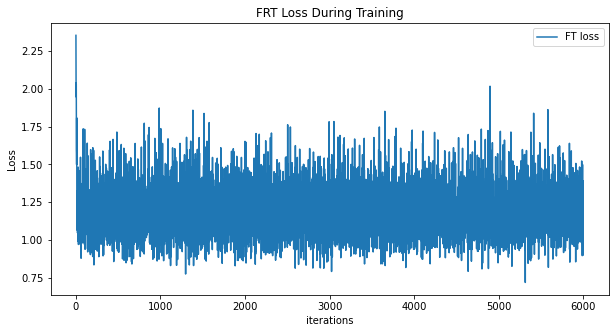

In [13]:
model_ft, FT_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=500)
plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training")
plt.plot(FT_losses, label="FT loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
img=Image.open(r'C:\Users\user\ML\Session-4\data\test_me\val\sachin\sachin9.jpg')
tensor = data_transforms['val'](img).unsqueeze(0)
print(tensor.shape)
model_ft(tensor.to(device)).argmax().item()

torch.Size([1, 3, 160, 160])


8

In [15]:
traced_model=torch.jit.trace(model_ft.cpu(),torch.randn(10,3,160,160))
torch.jit.save(traced_model, r"C:\Users\user\ML\Session-4\MTCNN.pt")